# Esercitazione III
1. Addestrare una CNN per la classificazione delle immagini nel dataset CIFAR-10.
2. Provare data augmentation per migliorare la generalizzazione.
3. Utilizzare gli scheduler di learning rate.
4. Aggiungere Dropout o BatchNorm per la regolarizzazione.
5. Implementare early stopping monitorando la perdita di loss.
6. Sostituire la CNN con un modello pre-addestrato come ResNet o MobileNet.

## Set-up

Per le analisi, scegliamo il GPU se è disponibile, e spostiamo tutti i tensori e il modello su `device`.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


## Data preparation 

Inizialmente, normalizziamo i dati tramite statistiche pre-calcolate per ciascun canale `RGB`. Dopodiché, si aggiunge `padding`, flip casuale orizzontale e random crop. Sul test set invece, si fa solo normalizzazione, non data augmentations casuali delle immagini.
I mini-batch considerati sono di numerosità `400`, questo vuol dire che analizziamo quasi 125 batch per epoca.

In [3]:
stats = ((0.4914, 0.4822, 0.4465),
         (0.2023, 0.1994, 0.2010))

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

train_ds = CIFAR10(root='data/', train=True, transform=train_tfms, download=True)
test_ds  = CIFAR10(root='data/', train=False, transform=test_tfms, download=True)

train_dl = DataLoader(train_ds, batch_size=400, shuffle=True, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=400, num_workers=2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Definizione del modello

Per non scrivere lo stesso codice diverse volte, creo la funzione di `conv_block`. Il `kernel_size` è pari a 3, quindi il filtro considera un quadrato di dimensioni `3 x 3`, e inoltre, aggiungiamo anche `padding = 1` per mantenere le stesse dimensioni dell'immagine anche in uscita. \
Viene utilizzata anche la tecnica di `Batch Normalization` per normalizzare l'output della convoluzione. La funzione di attivazione è `ReLU`, dove la trasformazione avviene sullo stesso tensore senza crearne uno nuovo (scelta più efficiente in termini di memoria). 
Se viene applicato anche `pool`, allora si aggiunge un `Max Pooling` con finestra `2x2`, in modo da ridurre la dimensione spaziale.  

Il concetto chiave di `ResNet` è il `residual connection`, cioè connessioni che saltano alcuni strati e sommano direttamente l'input con l'output di blocchi convoluzionali più profondi. 
Il primo livello `self.conv1`,prende in input l'immagine RGB e crea 64 canali di feature. \
Il secondo livello `self.conv2` passa da 64 canali a 128, qui si applica la tecnica di `MaxPooling`. La dimensione dell'immagine scende da `32x32` a `16x16`.
Questi 2 blocchi servono per estrarre le caratteristiche di base dell'immagine.

Il primo blocco residuo `self.res1` fa due convoluzioni consecutive, e nel `forward()` il suo output verrà sommato con l'input. 
`out = self.res1(out) + out`

Nel terzo `self.conv3` e quarto livello `self.conv4`, si aumenta ulteriormente il numero di canali da `128` a `512`, e qui la rete cattura pattern più complessi come oggetti, contorni e texture. 

Il classificatore finale `self.classifier` riduce la dimensione a `1x1`, condensa tutte le feature in un vettore, e spegne casualmente il `20%` dei neuroni durante l'allenamento per evitare l'overfitting. 

In [4]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128),
                                  conv_block(128, 128))
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512),
                                  conv_block(512, 512))
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

model = ResNet9(3, 10).to(device)

## Addestramento e risultati

Per raggiungere il `90%` dell'accuracy entro 8 epoche, possiamo impostare questi iperparametri: \
Un `max_lr` a `0.01`, che rappresenta il valore massimo nel ciclo `OneCycle` il quale converge più rapidamente, e viene aggiornato ad ogni batch con `sched.step()`.
Si utilizza anche un `grad_clip = 0.1` per limitare valori del gradiente $\pm$ `0.1`. 
Il valore della regolarizzazione `weight_decay` è impostato a `1e-4`.

Epoch [1/8] | Train Loss: 0.3579 | Val Loss: 0.7646 | Val Acc: 76.30%
Epoch [2/8] | Train Loss: 0.5652 | Val Loss: 1.1393 | Val Acc: 64.87%
Epoch [3/8] | Train Loss: 0.5806 | Val Loss: 0.6435 | Val Acc: 78.69%
Epoch [4/8] | Train Loss: 0.4984 | Val Loss: 0.6729 | Val Acc: 79.30%
Epoch [5/8] | Train Loss: 0.4335 | Val Loss: 0.4705 | Val Acc: 84.00%
Epoch [6/8] | Train Loss: 0.3411 | Val Loss: 0.3676 | Val Acc: 87.61%
Epoch [7/8] | Train Loss: 0.2459 | Val Loss: 0.2806 | Val Acc: 90.76%
Epoch [8/8] | Train Loss: 0.1721 | Val Loss: 0.2606 | Val Acc: 91.51%


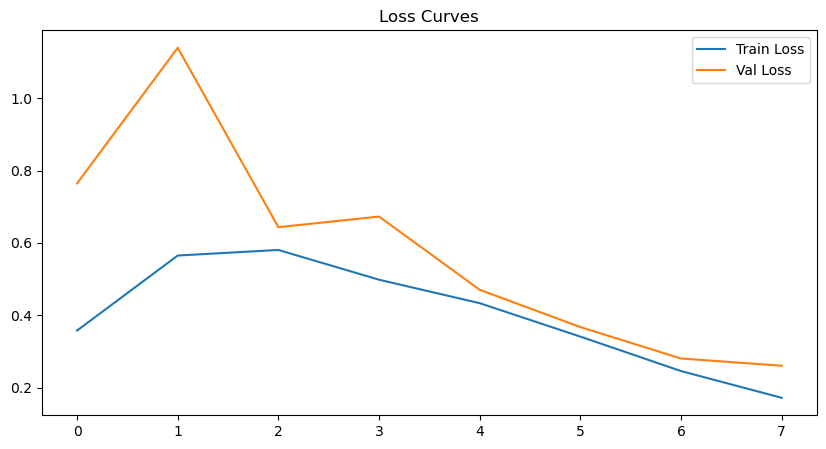

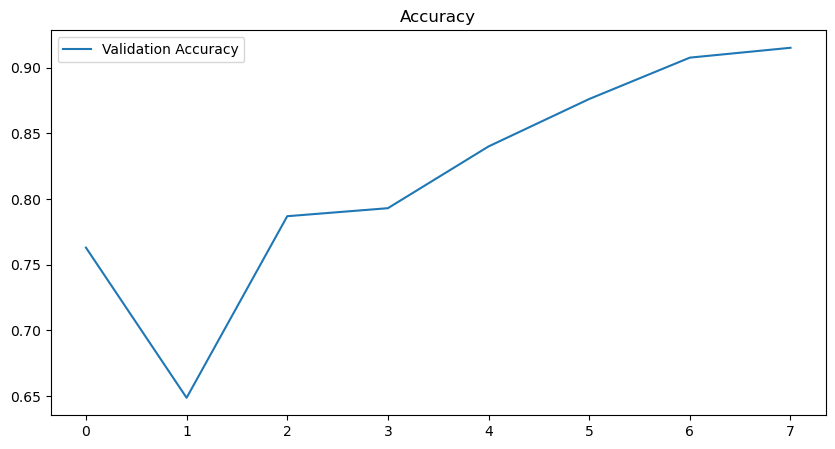

In [6]:
# Addestramento
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    losses, accs = [], []
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        acc = accuracy(outputs, labels)
        losses.append(loss.item())
        accs.append(acc.item())
    return np.mean(losses), np.mean(accs)

# Training loop
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_dl))

train_losses, val_losses, val_accs = [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, labels in train_dl:
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        loss = F.cross_entropy(out, labels)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        optimizer.step()
        sched.step()
        train_loss += loss.item()
    
    val_loss, val_acc = evaluate(model, test_dl)
    train_losses.append(train_loss / len(train_dl))
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss/len(train_dl):.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

# Risultati
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curves")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_accs, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

## Riproducibilità e tempi di addestramento
l'addestramento richiede circa 5 minuti su un laptop con queste caratteristiche:

``` yaml
OS: EndeavourOS Linux x86_64
Kernel: 6.17.6-arch1-1
CPU: Intel i7-8850H (12) @ 4.30GHz
GPU: NVIDIA GeForce GTX 1050 Mobile
RAM: 32 GB
```